In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="data/ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="data/ratings_test.txt")

('data/ratings_test.txt', <http.client.HTTPMessage at 0x28e34e1f890>)

In [3]:
train_data = pd.read_table('data/ratings_train.txt')
test_data = pd.read_table('data/ratings_test.txt')

In [4]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
display(train_data[:5])
print('테스트용 리뷰 개수 :',len(test_data))
display(test_data[:5])

훈련용 리뷰 개수 : 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


테스트용 리뷰 개수 : 50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

총 샘플의 수 : 150000


<Axes: xlabel='label'>

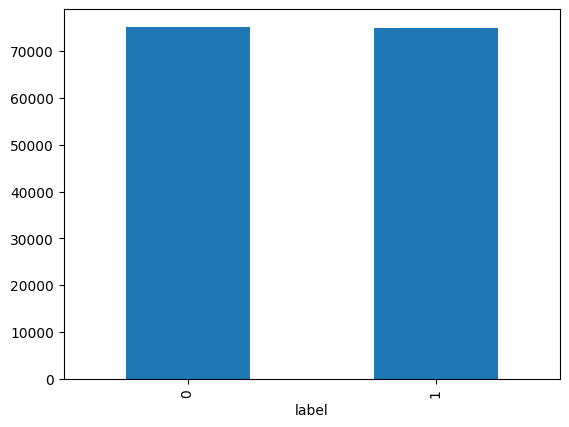

In [7]:
print('총 샘플의 수 :',len(train_data))
train_data['label'].value_counts().plot(kind = 'bar')

In [8]:
print(train_data.groupby('label').size().reset_index(name = 'count'))
print(train_data.isnull().values.any())
print(train_data.isnull().sum())

   label  count
0      0  75173
1      1  74827
True
id          0
document    5
label       0
dtype: int64


In [9]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [10]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [11]:
print(len(train_data))

149995


In [12]:
#알파벳과 공백을 제외하고 모두 제거
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

do you expect people to read the FAQ etc and actually accept hard atheism


In [13]:
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data['document'] = train_data['document'].replace('', np.nan)
print(train_data.isnull().sum())

id             0
document    1255
label          0
dtype: int64


In [14]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

148740


In [15]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['document'] = test_data['document'].replace('', np.nan) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


In [ ]:
with open('data/stopwords.txt') as f:
    print(f.readlines(end='\n'))

['거랜데\n', '로서\n', '해당\n', '대해\n', '갈수\n', '볼\n', '박\n', '점\n', '결\n', '뿐\n', '곤\n', '배\n', '편\n', '까르띠\n', '척\n', '찬\n', '클릭\n', '요요\n', '프로필\n', '두\n', '도\n', '드릴\n', '다그\n', '로시\n', '출처\n', '도\n', '아이엠\n', '벤자민\n', '할애\n', '채택\n', '성심\n', '성의껏\n', '가지\n', '제이\n', '바로가기\n', '채널\n', '씨엘\n', '파\n', '즐\n', '안녕하십니까\n', '질문\n', '문의\n', '답변\n', '굳이\n', '제공\n', '최\n', '나은\n', '보\n', '유량\n', '주시\n', '현\n', '쯤\n', '총\n', '서나\n', '아예\n', '바\n', '벙\n', '빼\n', '곧바로\n', '나름\n', '그게\n', '그냥\n', '그대로\n', '그동안\n', '덜\n', '스\n', '놀란\n', '더욱\n', '김\n', '틀\n', '번의\n', '나중\n', '무소\n', '더니\n', '무니\n', '말씀드렷\n', '보아\n', '이내\n', '섣불리\n', '여러가지\n', '여지\n', '진짜\n', '전혀\n', '이제\n', '지금\n', '이외\n', '잠도\n', '일이\n', '이분\n', '해도\n', '워낙\n', '여럿\n', '뭔가\n', '셧습니\n', '서요\n', '었어\n', '어차피\n', '어처구니\n', '어쨌든\n', '살짝\n', '찾기\n', '외\n', '그거\n', '보이\n', '한일\n', '관련\n', '줌\n', '료\n', '뭘\n', '셨습\n', '듯\n', '곳\n', '려고\n', '얘기\n', '몇번\n', '끝\n', '때문\n', '고려\n', '경우\n', '거나\n', '위해\n', '채\n', '므\n', '내\n', '쪽\n', '통\n', '다해\n